# Machine Learning Engineer Nanodegree
## Capstone Project
## Di-Tech Challenge: Forecasting Supply-demand Gap

# Part - II Data Analysis

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set_context('poster')

from sklearn import cross_validation
from sklearn import metrics
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

import xgboost as xgb

## Load training and test data

In [3]:
train_data = pd.read_csv('../clean_data/training_all_data.csv')
test_data = pd.read_csv('../clean_data/test_all_data.csv')
target_set = pd.read_csv('../clean_data/target_set.csv')

## Exploratory Analysis

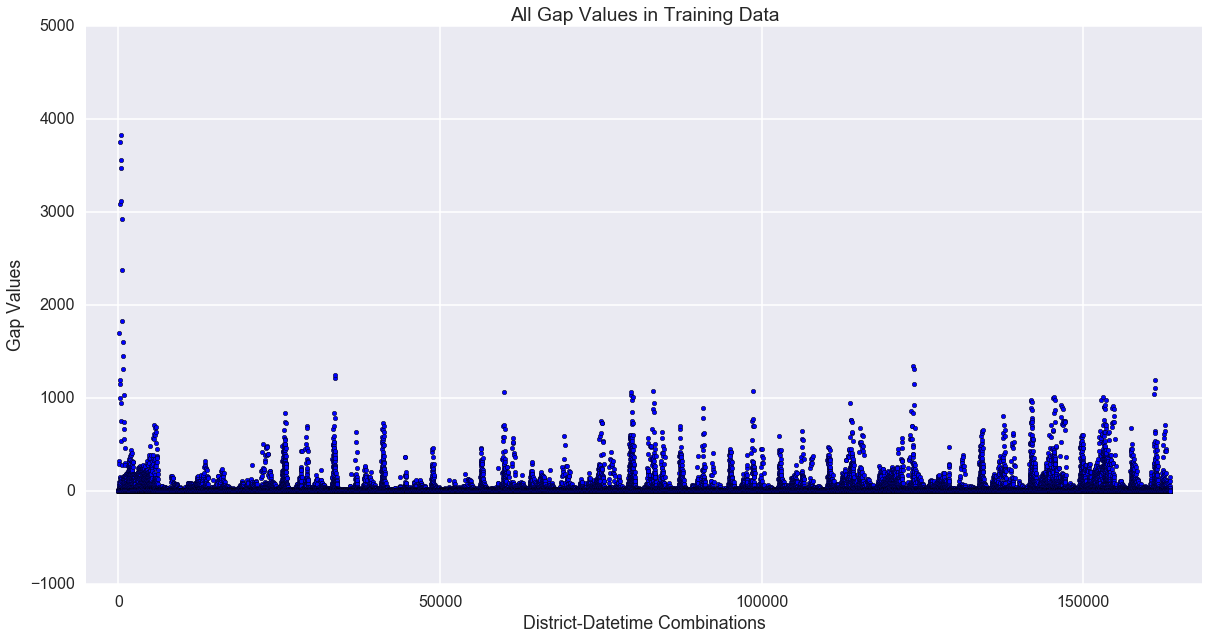

In [4]:
plt.figure(figsize=(20, 10))

x = train_data.index.values
y = train_data['gap'].values

plt.title('All Gap Values in Training Data')
plt.xlabel('District-Datetime Combinations')
plt.ylabel('Gap Values')
plt.scatter(x, y)
plt.xlim([-5000,train_data.shape[0]+5000])
plt.savefig('../plots/All Gap Values in Training Data.png')

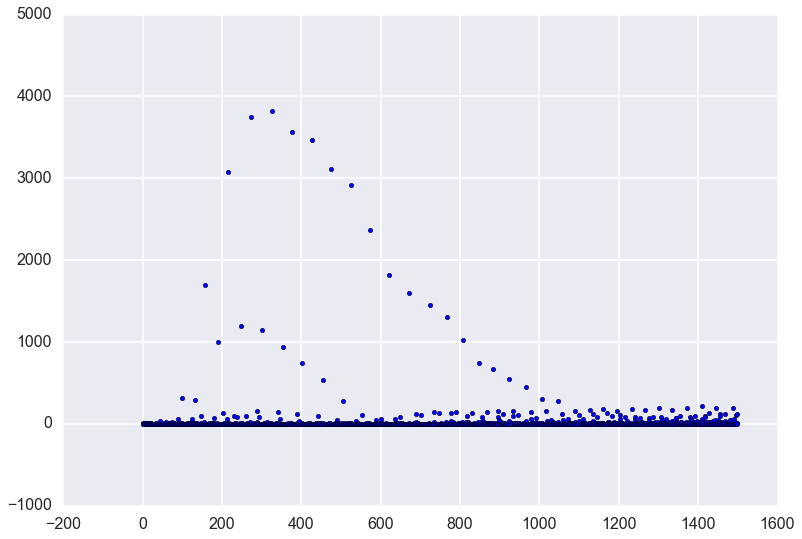

In [5]:
# zoom in on the spike
plt.scatter(train_data.index[:1500], train_data.gap[:1500])
plt.savefig('../plots/Zoom in on Spike.png')

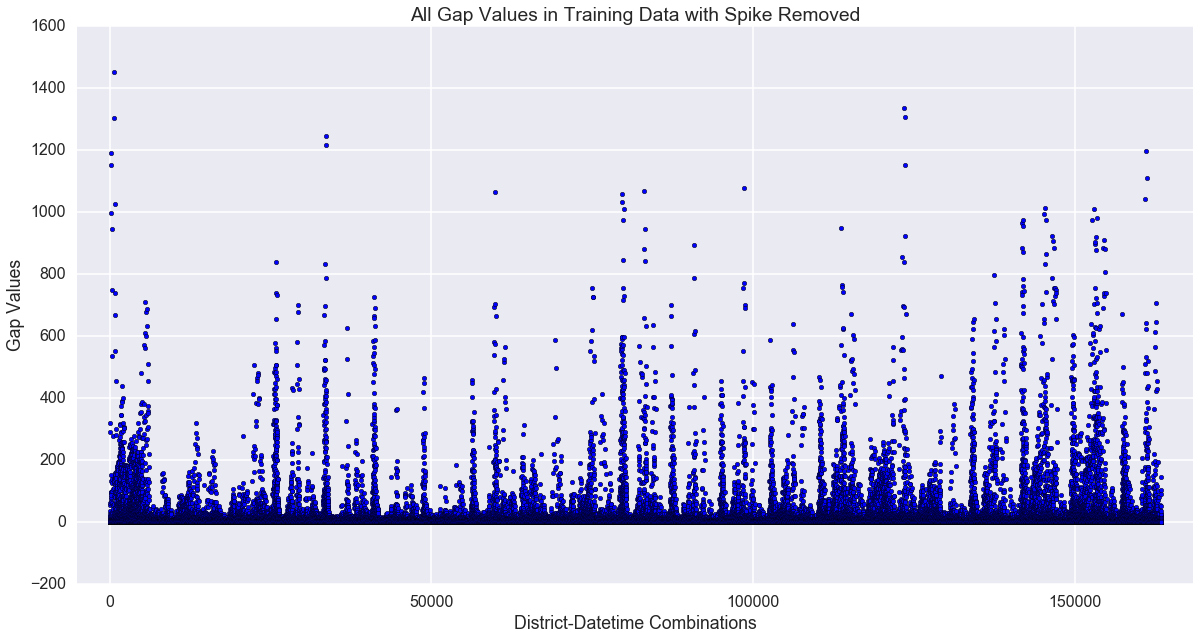

In [6]:
# the spike values happened on the midnight of 2016-01-01 due to the new year's eve activities
# remove values above 1500 as outliers
train_data = train_data[train_data['gap'] < 1500]
train_data.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20, 10))

x = train_data.index.values
y = train_data['gap'].values

plt.title('All Gap Values in Training Data with Spike Removed')
plt.xlabel('District-Datetime Combinations')
plt.ylabel('Gap Values')
plt.scatter(x, y)
plt.xlim([-5000,train_data.shape[0]+5000])
plt.savefig('../plots/All Gap Values in Training Data with Peak Removed.png')

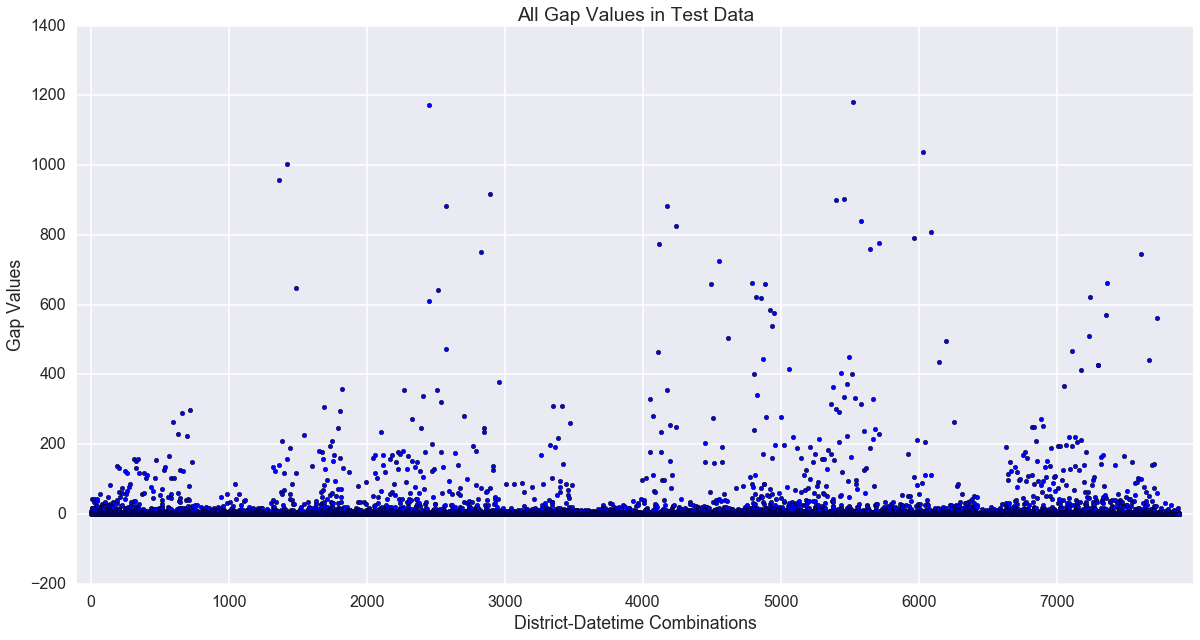

In [7]:
plt.figure(figsize=(20, 10))

x = test_data.index.values
y = test_data['gap'].values

plt.title('All Gap Values in Test Data')
plt.xlabel('District-Datetime Combinations')
plt.ylabel('Gap Values')
plt.scatter(x, y)
plt.xlim([-100,test_data.shape[0]+100])
plt.savefig('../plots/All Gap Values in Test Data.png')

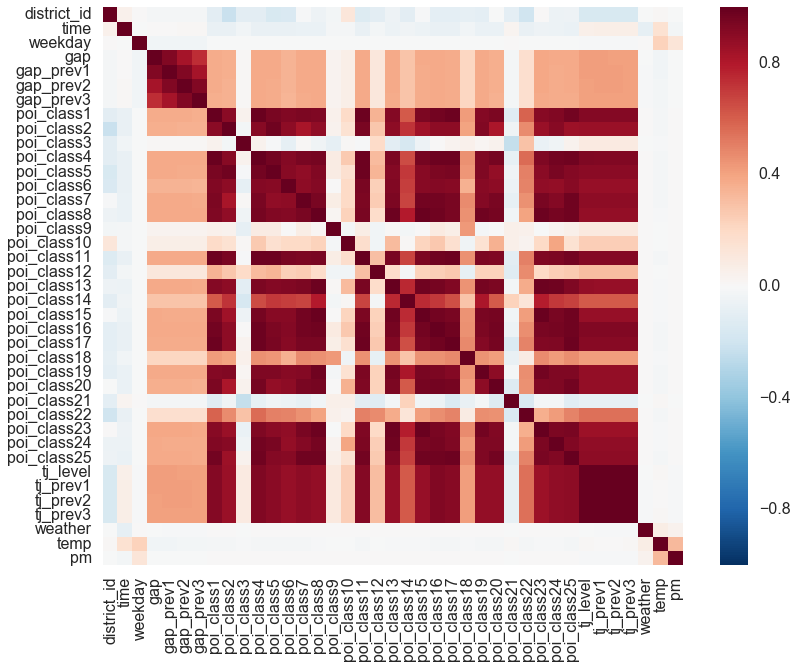

In [8]:
# visulize correlations of features with a heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(train_data.corr())
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.savefig('../plots/Heatmap of Correlations Between Features.png')

# Part - III Model Building

In [9]:
# combine training data and test data to training set
train = pd.concat([train_data, test_data], axis=0)
train = train.drop(['datetime', 'district_datetime'], axis=1)

# get target set to be predicted
target = target_set.drop(['datetime', 'district_datetime'], axis=1)

# get the feature list
features = train.drop('gap', axis=1, inplace=False).columns.values.tolist()

## XGBoost Implementation

In [10]:
# A quick XGBoost implementation
# split training and test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train[features], train['gap'],
                                                                     test_size=0.4, random_state=0)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


# define customized MAPE evaluation metric for XGBoost
def mapeEval(preds, dtrain):
    gaps = dtrain.get_label()
    preds[preds<1] = 1
    err = np.abs(gaps - preds) / gaps
    err[np.where(gaps==0)[0]] = 0
    err = np.mean(err)

    return 'MAPE', err


param = {'max_depth':3, 'eta':0.2, 'silent':1}
bst = xgb.train(param, dtrain, feval=mapeEval)

print 'MAPE of a basic XGBoost: {}'.format(mapeEval(bst.predict(dtest), dtest)[1])

# # make prediction
# dtarget = xgb.DMatrix(target[features], missing=None)
# preds = bst.predict(dtarget)

MAPE of a basic XGBoost: 0.379710167646


In [11]:
# some scikit-learn regressors
def get_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred[y_pred < 1] = 1
    err = np.abs((y_true - y_pred) / y_true)
    err[np.where(y_true==0)[0]] = 0
    mape = np.abs(np.mean(err))
    return mape

X_train, X_test, y_train, y_test = cross_validation.train_test_split(train[features],train['gap'],
                                                                     test_size=0.4, random_state=0)

gbreg = GradientBoostingRegressor() 
rfreg = RandomForestRegressor() 
abreg = AdaBoostRegressor() 

gbreg.fit(X_train, y_train)
rfreg.fit(X_train, y_train)
abreg.fit(X_train, y_train)

gbpreds = gbreg.predict(X_test)
rfpreds = rfreg.predict(X_test)
abpreds = abreg.predict(X_test)

print 'MAPE of Gradient Boosting Regressor: {}'.format(get_mape(y_test, gbpreds))
print 'MAPE of Random Forest Regressor: {}'.format(get_mape(y_test, rfpreds))
print 'MAPE of AdaBoost Regressor: {}'.format(get_mape(y_test, abpreds))

MAPE of Gradient Boosting Regressor: 0.389279218256
MAPE of Random Forest Regressor: 0.43694973536
MAPE of AdaBoost Regressor: 1.891399788


## Parameter Tuning

In [12]:
# define customized scoring function
def get_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred[y_pred < 1] = 1
    error = np.absolute((y_true - y_pred) / y_true)
    error[np.where(y_true==0)[0]] = 0
    mape = np.mean(error)
    return mape


scoring_function = metrics.make_scorer(get_mape, greater_is_better=False)
# NOTE: 'greater_is_better=boolean' means whether score_func is a score function (default), meaning high is good,
# or a loss function, meaning low is good. In the latter case, the scorer object will sign-flip the outcome of the
# score_func.

gs_results = []  # records best gridsearch results

In [13]:
# Tune objective
param_set0 = {
    'objective': ('reg:linear', 'count:poisson')
}

xgb0 = xgb.XGBRegressor(silent=True, nthread=1, max_delta_step=0.7, seed=0)

gsearch0 = GridSearchCV(estimator=xgb0, param_grid=param_set0, scoring=scoring_function, n_jobs=1, cv=5)
gsearch0.fit(train[features], train['gap'])

gs_results.append(gsearch0.grid_scores_)
print gsearch0.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch0.best_score_), gsearch0.best_params_)

[mean: -0.37562, std: 0.00943, params: {'objective': 'reg:linear'}, mean: -0.39983, std: 0.01329, params: {'objective': 'count:poisson'}]
Best MAPE = 0.37561902302 at {'objective': 'reg:linear'}


In [14]:
# Tune max_depth
param_set1 = {
    'max_depth': (6, 8, 10)
}

xgb1 = xgb.XGBRegressor(silent=True, nthread=1, seed=0, objective='reg:linear')

gsearch1 = GridSearchCV(estimator=xgb1, param_grid=param_set1, scoring=scoring_function, n_jobs=1, cv=5)
gsearch1.fit(train[features], train['gap'])

gs_results.append(gsearch1.grid_scores_)
print gsearch1.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch1.best_score_), gsearch1.best_params_)

[mean: -0.41228, std: 0.04947, params: {'max_depth': 6}, mean: -0.40809, std: 0.05120, params: {'max_depth': 8}, mean: -0.41202, std: 0.06310, params: {'max_depth': 10}]
Best MAPE = 0.408092372755 at {'max_depth': 8}


In [15]:
# Tune min_childe_weight
param_set2 = {
    'min_child_weight': (3, 5, 7)
}

xgb2 = xgb.XGBRegressor(max_depth=8, objective='reg:linear', silent=True, nthread=1, seed=0)

gsearch2 = GridSearchCV(estimator=xgb2, param_grid=param_set2, scoring=scoring_function, n_jobs=1, cv=5)
gsearch2.fit(train[features], train['gap'])

gs_results.append(gsearch2.grid_scores_)
print gsearch2.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch2.best_score_), gsearch2.best_params_)

[mean: -0.40303, std: 0.04981, params: {'min_child_weight': 3}, mean: -0.41024, std: 0.05617, params: {'min_child_weight': 5}, mean: -0.40773, std: 0.04894, params: {'min_child_weight': 7}]
Best MAPE = 0.403033437067 at {'min_child_weight': 3}


In [16]:
# Tune gamma
param_set3 = {
    'gamma': (0, 2, 4)
}

xgb3 = xgb.XGBRegressor(max_depth=8, silent=True, objective='reg:linear', nthread=1, min_child_weight=3, seed=0)

gsearch3 = GridSearchCV(estimator=xgb3, param_grid=param_set3, scoring=scoring_function, n_jobs=1, cv=5)
gsearch3.fit(train[features], train['gap'])

gs_results.append(gsearch3.grid_scores_)
print gsearch3.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch3.best_score_), gsearch3.best_params_)

[mean: -0.40303, std: 0.04981, params: {'gamma': 0}, mean: -0.40267, std: 0.04870, params: {'gamma': 2}, mean: -0.40282, std: 0.04815, params: {'gamma': 4}]
Best MAPE = 0.402674771806 at {'gamma': 2}


In [17]:
# Tune reg_alpha
param_set4 = {
    'reg_alpha': (0, 2, 4)
}

xgb4 = xgb.XGBRegressor(max_depth=8, silent=True, objective='reg:linear', nthread=1, gamma=2, min_child_weight=3,
                        seed=0)

gsearch4 = GridSearchCV(estimator=xgb4, param_grid=param_set4, scoring=scoring_function, n_jobs=1, cv=5)
gsearch4.fit(train[features], train['gap'])

gs_results.append(gsearch4.grid_scores_)
print gsearch4.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch4.best_score_), gsearch4.best_params_)

[mean: -0.40267, std: 0.04870, params: {'reg_alpha': 0}, mean: -0.40788, std: 0.05886, params: {'reg_alpha': 2}, mean: -0.40888, std: 0.04907, params: {'reg_alpha': 4}]
Best MAPE = 0.402674771806 at {'reg_alpha': 0}


In [18]:
# Tune reg_lambda
param_set5 = {
    'reg_lambda': (1, 3, 5)
}

xgb5 = xgb.XGBRegressor(max_depth=8, silent=True, objective='reg:linear', nthread=1, gamma=2, min_child_weight=3,
                        reg_alpha=0, seed=0)

gsearch5 = GridSearchCV(estimator=xgb5, param_grid=param_set5, scoring=scoring_function, n_jobs=1, cv=5)
gsearch5.fit(train[features], train['gap'])

gs_results.append(gsearch5.grid_scores_)
print gsearch5.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch5.best_score_), gsearch5.best_params_)

[mean: -0.40267, std: 0.04870, params: {'reg_lambda': 1}, mean: -0.39913, std: 0.04192, params: {'reg_lambda': 3}, mean: -0.40561, std: 0.04942, params: {'reg_lambda': 5}]
Best MAPE = 0.399128737386 at {'reg_lambda': 3}


In [19]:
# Tune subsample
param_set6 = {
    'subsample': (0.5, 1)
}

xgb6 = xgb.XGBRegressor(max_depth=8, silent=True, objective='reg:linear', nthread=1, gamma=2, min_child_weight=3,
                        reg_alpha=0, reg_lambda=3, seed=0)

gsearch6 = GridSearchCV(estimator=xgb6, param_grid=param_set6, scoring=scoring_function, n_jobs=1, cv=5)
gsearch6.fit(train[features], train['gap'])

gs_results.append(gsearch6.grid_scores_)
print gsearch6.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch6.best_score_), gsearch6.best_params_)

[mean: -0.40807, std: 0.05268, params: {'subsample': 0.5}, mean: -0.39913, std: 0.04192, params: {'subsample': 1}]
Best MAPE = 0.399128737386 at {'subsample': 1}


In [20]:
# Tune colsample_bytree
param_set7 = {
    'colsample_bytree': (0.5, 1)
}

xgb7 = xgb.XGBRegressor(max_depth=8, silent=True, objective='reg:linear', nthread=1, gamma=0, min_child_weight=3,
                        subsample=1, reg_alpha=0, reg_lambda=3, seed=0)

gsearch7 = GridSearchCV(estimator=xgb7, param_grid=param_set7, scoring=scoring_function, n_jobs=1, cv=5)
gsearch7.fit(train[features], train['gap'])

gs_results.append(gsearch7.grid_scores_)
print gsearch7.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch7.best_score_), gsearch7.best_params_)

[mean: -0.41891, std: 0.06080, params: {'colsample_bytree': 0.5}, mean: -0.39943, std: 0.04160, params: {'colsample_bytree': 1}]
Best MAPE = 0.399432778347 at {'colsample_bytree': 1}


In [21]:
# Tune colsample_bylevel
param_set8 = {
    'colsample_bylevel': (0.5, 1)
}

xgb8 = xgb.XGBRegressor(max_depth=8, silent=True, objective='reg:linear', nthread=1, gamma=0, min_child_weight=3,
                        subsample=1, colsample_bytree=1, reg_alpha=0, reg_lambda=3, seed=0)

gsearch8 = GridSearchCV(estimator=xgb8, param_grid=param_set8, scoring=scoring_function, n_jobs=1, cv=5)
gsearch8.fit(train[features], train['gap'])

gs_results.append(gsearch8.grid_scores_)
print gsearch8.grid_scores_
print "Best MAPE = {0} at {1}".format(abs(gsearch8.best_score_), gsearch8.best_params_)

[mean: -0.40876, std: 0.04350, params: {'colsample_bylevel': 0.5}, mean: -0.39943, std: 0.04160, params: {'colsample_bylevel': 1}]
Best MAPE = 0.399432778347 at {'colsample_bylevel': 1}


## Final Model

In [22]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(train[features],train['gap'],
                                                                     test_size=0.4, random_state=0)
# Final Model
final_xgb = xgb.XGBRegressor(max_depth=8, learning_rate=0.01, n_estimators=5000, silent=True, objective='reg:linear', 
                             nthread=1, gamma=2, min_child_weight=3, subsample=1, colsample_bytree=1, 
                             colsample_bylevel=1, reg_alpha=0, reg_lambda=3, seed=0)

final_xgb.fit(X_train, y_train)
preds = final_xgb.predict(X_test)

print 'MAPE of Final Model:{}'.format(get_mape(y_test, preds))

MAPE of Final Model:0.36290732152


In [23]:
target_preds = final_xgb.predict(target[features])
# generate submission file
pd.options.mode.chained_assignment = None  # default='warn'

results = pd.concat([target_set[['district_datetime', 'gap']], pd.Series(target_preds, name='preds')], axis=1)
results['district'] = results['district_datetime'].apply(lambda x: x.split(',')[0])
results['datetime'] = results['district_datetime'].apply(lambda x: x.split(',')[1])
output = results[results['gap'].isnull()]
output.drop(['gap', 'district_datetime'], axis=1, inplace=True)
output = output[['district', 'datetime', 'preds']]
output['preds'][output['preds'] < 1] = 1.000
output['preds'] = output['preds'].round(decimals=1)

output.to_csv('../submissions/output_{}.csv'.format(datetime.strftime(datetime.now(), '%Y%m%d%H%M%S')), 
              float_format='%.1f', index=False, header=False)

## Feature Importance

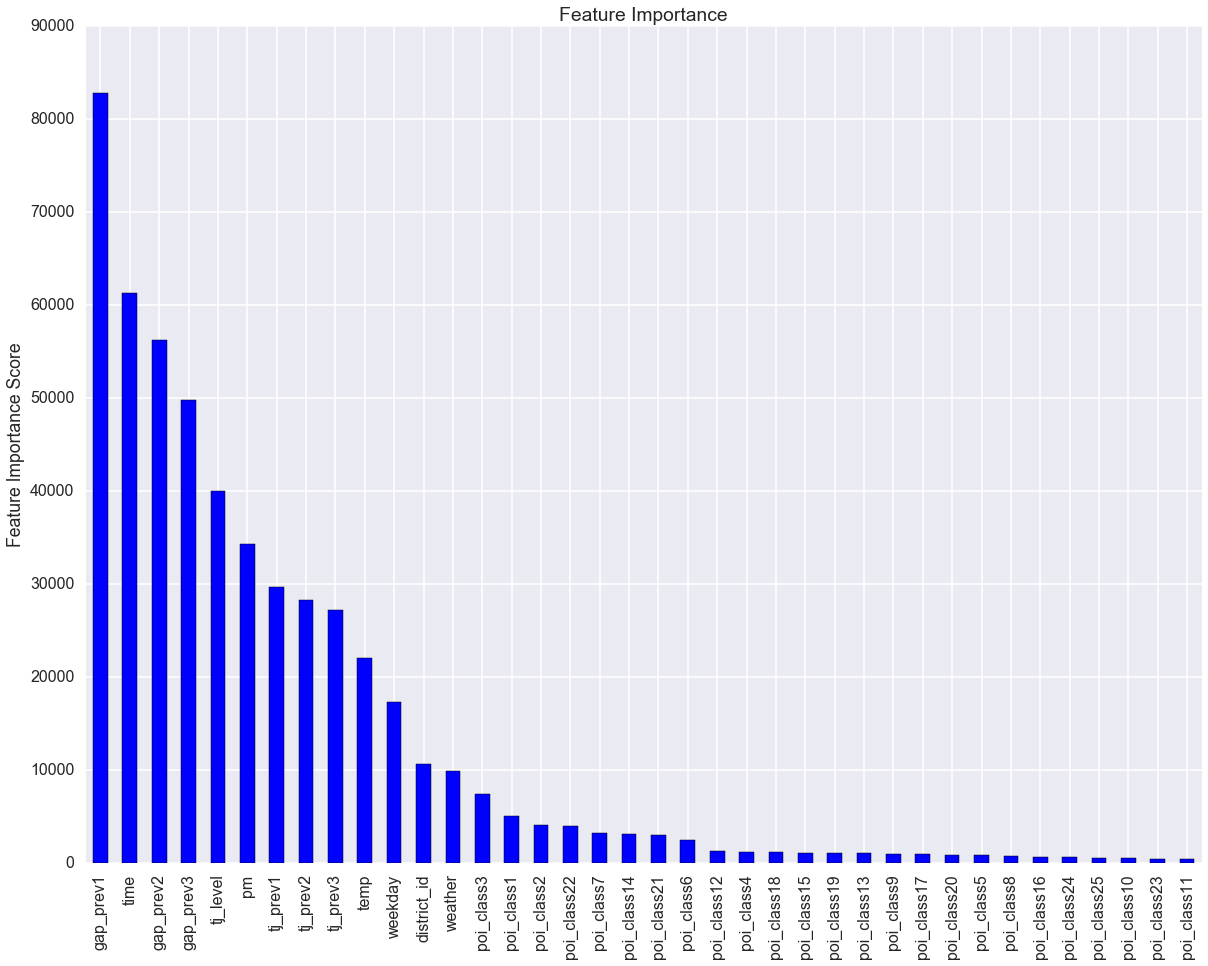

In [25]:
# feature importance
plt.figure(figsize=(20, 15))
feature_importance = pd.Series(final_xgb.booster().get_fscore()).sort_values(ascending=False)
feature_importance.plot(kind='bar', title='Feature Importance')
plt.ylabel('Feature Importance Score')
plt.savefig('../plots/Feature Importance.png')